In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import scipy.sparse as sp
import torch.nn as nn
from node2vec import Node2Vec
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
import itertools
import dgl
import random

/Users/afnanmir/miniforge3/envs/mlrn/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from dgl.nn import SAGEConv
from dgl.nn import GraphConv
import dgl.function as fn

# ----------- 2. create model -------------- #
# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

class GraphGCN(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphGCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats, allow_zero_in_degree=True)
        self.conv2 = GraphConv(h_feats, h_feats, allow_zero_in_degree=True)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

In [3]:
G_5day = nx.read_gexf("../graph_creation/2020-07-01__to__2020-07-05__15-overlap__hashmap.gexf")
G_6day = nx.read_gexf("../graph_creation/2020-07-01__to__2020-07-06__15-overlap__hashmap.gexf")

In [4]:
sorted_6day = sorted(G_6day.nodes())
node2id_6day = {n: i for i, n in enumerate(sorted_6day)}

In [5]:
# Create the training set
positive_edges_train = list(G_5day.edges())
negative_edges_train = [(u, v) for u, v in random.sample(list(nx.non_edges(G_5day)), len(positive_edges_train))]

# Create the test set
positive_edges_test = list(set(G_6day.edges()) - set(G_5day.edges()))
negative_edges_test = [(u, v) for u, v in random.sample(list(nx.non_edges(G_6day)), len(positive_edges_test))]

# TODO: Train and test a link prediction model using the training and test sets

In [6]:
# Create the training set
positive_edges_train_tensors = torch.tensor([[node2id_6day[u], node2id_6day[v]] for u, v in positive_edges_train])
negative_edges_train_tensors = torch.tensor([[node2id_6day[u], node2id_6day[v]] for u, v in negative_edges_train])

# Create the test set
positive_edges_test_tensors = torch.tensor([[node2id_6day[u], node2id_6day[v]] for u, v in positive_edges_test])
negative_edges_test_tensors = torch.tensor([[node2id_6day[u], node2id_6day[v]] for u, v in negative_edges_test])

In [7]:
train_pos_u = positive_edges_train_tensors[:, 0]
train_pos_v = positive_edges_train_tensors[:, 1]

train_neg_u = negative_edges_train_tensors[:, 0]
train_neg_v = negative_edges_train_tensors[:, 1]

In [8]:
test_pos_u = positive_edges_test_tensors[:, 0]
test_pos_v = positive_edges_test_tensors[:, 1]

test_neg_u = negative_edges_test_tensors[:, 0]
test_neg_v = negative_edges_test_tensors[:, 1]

In [9]:
# Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
node2vec = Node2Vec(G_6day, workers=4)
# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)

node_embeddings = np.array([model.wv.get_vector(str(node)) for node in G_6day.nodes()])
node_embedding_tensor = torch.tensor(node_embeddings)
node_features = node_embedding_tensor

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:42<00:00, 21.36s/it]


In [10]:
node_embeddings = np.array([model.wv.get_vector(str(node)) for node in sorted_6day])
node_embedding_tensor = torch.tensor(node_embeddings)
node_features = node_embedding_tensor

In [11]:
# create dictionary of node2vec embeddings
node2vec_embeds_dict = {}
for i, node in enumerate(sorted_6day):
    node2vec_embeds_dict[node] = node_embedding_tensor[i]

In [12]:
import pickle
with open("node2vec_tensors_6.pkl", "wb") as f:
    pickle.dump(node_embedding_tensor, f)

nodes_list = list(sorted(G_6day.nodes()))
with open("nodes_list_6.pkl", "wb") as f:
    pickle.dump(nodes_list, f)

In [13]:
# load the dictionary that is pickled in the feature computation directory in the main.ipynb
import pickle
with open('feature_combination/final_node_features.pkl', 'rb') as handle:
    device_to_features = pickle.load(handle)

In [14]:
# create dictionary of node2vec embeddings
node2vec_embeds_dict = {}
for i, node in enumerate(sorted_6day):
    node2vec_embeds_dict[node] = node_embedding_tensor[i]

In [15]:
# concatenate node2vec embeddings with the features
node_embeddings_np = np.array([np.concatenate((model.wv.get_vector(str(node)), np.array(list(device_to_features[node].values()), dtype=np.float32)), axis=0) for node in sorted(G_6day.nodes())])
node_embedding_tensor = torch.tensor(node_embeddings_np)
node_features = node_embedding_tensor

In [16]:
dgl_6 = dgl.from_networkx(G_6day)

In [17]:
test_pos_edge_ids = dgl_6.edge_ids(test_pos_u, test_pos_v)

In [18]:
train_g = dgl.remove_edges(dgl_6, test_pos_edge_ids)

In [19]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=dgl_6.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=dgl_6.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=dgl_6.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=dgl_6.number_of_nodes())

In [23]:
# dgl_model = GraphSAGE(node_features.shape[1], 16)
dgl_model = GraphGCN(node_features.shape[1], 16)
# You can replace DotPredictor with MLPPredictor.
#pred = MLPPredictor(16)
pred = DotPredictor()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In epoch 0, loss: 0.97563636302948
In epoch 5, loss: 0.6038513779640198
In epoch 10, loss: 0.5812763571739197
In epoch 15, loss: 0.5390375256538391
In epoch 20, loss: 0.5177146196365356
In epoch 25, loss: 0.4977570176124573
In epoch 30, loss: 0.4851294755935669
In epoch 35, loss: 0.47931385040283203
In epoch 40, loss: 0.47613397240638733
In epoch 45, loss: 0.4717137813568115
In epoch 50, loss: 0.4681057929992676
In epoch 55, loss: 0.4657096862792969
In epoch 60, loss: 0.46334484219551086
In epoch 65, loss: 0.46073290705680847
In epoch 70, loss: 0.45827987790107727
In epoch 75, loss: 0.4562588930130005
In epoch 80, loss: 0.45461803674697876
In epoch 85, loss: 0.45314595103263855
In epoch 90, loss: 0.45181405544281006
In epoch 95, loss: 0.4506892263889313
In epoch 100, loss: 0.44973626732826233
In epoch 105, loss: 0.448830246925354
In epoch 110, loss: 0.4478926360607147
In epoch 115, loss: 0.44692227244377136
In epoch 120, loss: 0.44592583179473877
In epoch 125, loss: 0.4449300467967987


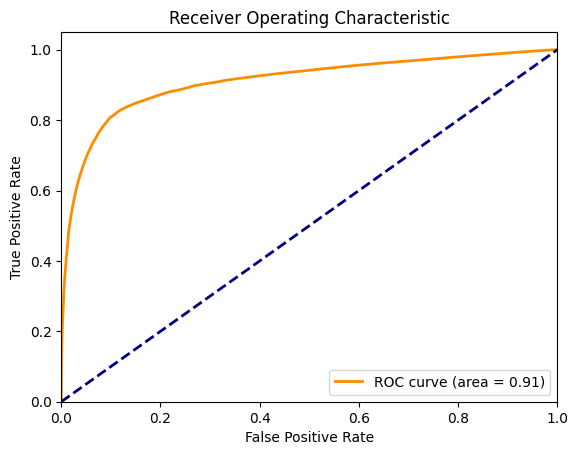

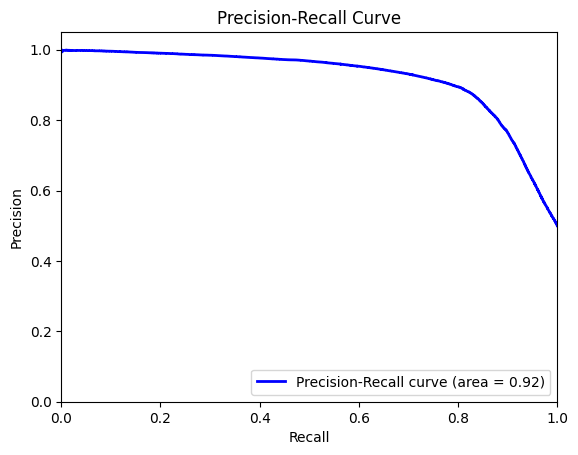

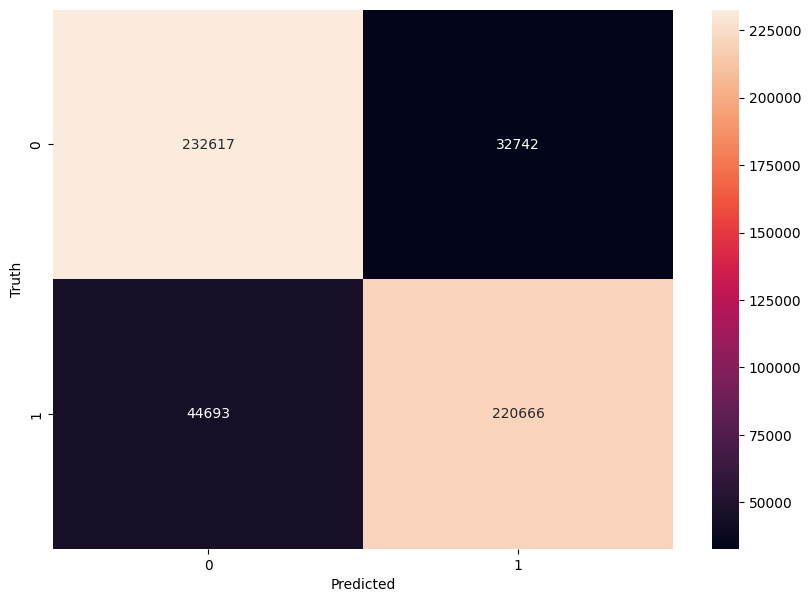

In [24]:
# ----------- 3. set up loss and optimizer -------------- #
# in this case, loss will in training loop
optimizer = torch.optim.Adam(itertools.chain(dgl_model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #
all_logits = []
loss_values = []
for e in range(1000):
    # forward
    h = dgl_model(train_g, node_features)
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)
    loss_values.append(loss.item())

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))

# ----------- 5. check results ------------------------ #
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix
import seaborn as sns
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    threshold = 0.5
    pos_pred = (pos_score > threshold).int()
    neg_pred = (neg_score > threshold).int()
    print('AUC', compute_auc(pos_score, neg_score))
    # get roc-auc curve
    fpr, tpr, thresholds = roc_curve(np.array([1]*len(pos_score) + [0]*len(neg_score)), np.array(pos_score.tolist() + neg_score.tolist()))
    roc_auc = auc(fpr, tpr)

    # get precision-recall curve
    precision, recall, _ = precision_recall_curve(np.array([1]*len(pos_score) + [0]*len(neg_score)), np.array(pos_score.tolist() + neg_score.tolist()))
    pr_auc = auc(recall, precision)

    # get confusion matrix
    cm = confusion_matrix(np.array([1]*len(pos_score) + [0]*len(neg_score)), np.array(pos_pred.tolist() + neg_pred.tolist()))
    # plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # plot Precision-Recall curve
    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Plot confusion matrix
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()
    

# Thumbnail credits: Link Prediction with Neo4j, Mark Needham
# sphinx_gallery_thumbnail_path = '_static/blitz_4_link_predict.png'

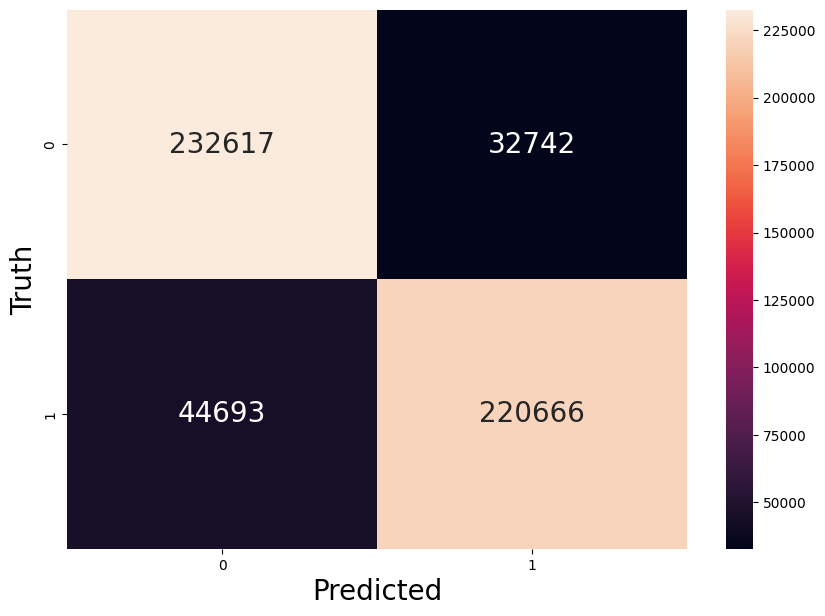

In [28]:
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 20})  # Increase font size
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Truth', fontsize=20)
plt.show()